# Yuhua Sandbox

## Algorithm to Automate Novelty Scoring

### Import Packages

In [120]:
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from functools import reduce
import openpyxl
import xlsxwriter

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.util import ngrams
from nltk import ngrams, FreqDist
from nltk.lm import NgramCounter
import string
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

from spacy.lang.en.stop_words import STOP_WORDS

from collections import Counter
import itertools

from sklearn.metrics.pairwise import cosine_similarity

from scipy import spatial

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

from nltk.cluster.kmeans import KMeansClusterer

from scipy import stats
from scipy.stats import pearsonr
import pingouin as pg
import os
import importlib
import utilities
%matplotlib inline

# load semspace

In [121]:
importlib.reload(utilities)

<module 'utilities' from '/Users/yyu/PycharmProjects/AUT-Scoring/scripts/utilities.py'>

In [2]:
splist=['cbow_6_ukwac_subtitle','cbow_subtitle','glove_6B','TASA']

In [9]:
folder='/Users/yyu/Box Sync/ORG-SCHOOL-WCAS-PSYCHOLOGY-BEEMAN-LAB/COAT/scoring/'
semspace_dict = {}
splist=['cbow_6_ukwac_subtitle','cbow_subtitle','glove_6B','TASA']
for sp in splist:
    semspace_dict[sp] = pd.read_csv(folder+'/semantic_spaces/'+sp+'.txt', delimiter = " ", header = None).set_index(0)


In [11]:
utilities.stopwords_edited

['n’t',
 'you',
 'no',
 'see',
 'where',
 'were',
 'under',
 'became',
 'perhaps',
 'do',
 'into',
 'been',
 'are',
 'none',
 'then',
 'whenever',
 "n't",
 'whereafter',
 'was',
 'on',
 'throughout',
 'he',
 'hundred',
 'nor',
 '’ve',
 'put',
 'move',
 'seeming',
 'through',
 'neither',
 '‘m',
 'empty',
 'wherever',
 'for',
 'front',
 'only',
 'toward',
 'something',
 'nine',
 '‘d',
 '’re',
 'keep',
 'i',
 'moreover',
 'seemed',
 "'ve",
 'along',
 'whole',
 'myself',
 '’ll',
 'upon',
 'before',
 'amongst',
 'three',
 'over',
 'formerly',
 'some',
 'whereupon',
 'as',
 'beside',
 'or',
 'please',
 'during',
 '’s',
 'a',
 'when',
 'be',
 'fifty',
 'herself',
 'to',
 'nobody',
 'ours',
 'hereby',
 'since',
 'itself',
 'one',
 "'ll",
 'ca',
 'can',
 'this',
 'enough',
 'below',
 'various',
 'could',
 'afterwards',
 'me',
 'well',
 'themselves',
 'it',
 'we',
 'next',
 'five',
 'yet',
 'own',
 'might',
 'had',
 'third',
 'just',
 '‘ve',
 'she',
 '‘s',
 'eight',
 'any',
 're',
 'without',
 '

# novelty

In [269]:
folder='/Users/yyu/PycharmProjects/AUT-Scoring/data/novelty/official/semdis/'
sd_df=pd.DataFrame()
for prompt in ['box','brick','chair','cup','key','pencil','rope','shoe']:
    sd_df=pd.concat([sd_df,pd.read_csv(folder+'autdata_official_semdis_'+prompt+'.csv')])

In [270]:
sd_df['novelty_m']=sd_df[['novelty_1','novelty_2']].mean(axis=1)

In [271]:
len(sd_df)

3403

In [272]:

#lemmatize
sd_df['response_processed']=sd_df.apply(lambda r: utilities.lemmatize(r['response'],utilities.stopwords_edited), axis=1)
#remove stim word
sd_df['response_processed']=sd_df.apply(lambda r: [x for x in r['response_processed'] if x!=r['item_nofill']], axis=1)


In [273]:
for sp in splist:
    sd_df['ewm_'+sp]=sd_df.apply(lambda r: utilities.get_ewm_cosdist(r['item_nofill'], r['response_processed'], semspace_dict[sp]), axis=1)
    sd_df['min_'+sp]=sd_df.apply(lambda r: utilities.get_minvec(r['item_nofill'], r['response_processed'], semspace_dict[sp]), axis=1)
  

In [274]:
sd_df['ewm_MEAN']=sd_df[['ewm_cbow_6_ukwac_subtitle','ewm_cbow_subtitle','ewm_glove_6B','ewm_TASA']].mean(axis=1)
sd_df['min_MEAN']=sd_df[['min_cbow_6_ukwac_subtitle','min_cbow_subtitle','min_glove_6B','min_TASA']].mean(axis=1)

In [275]:
sd_df.to_csv('/Users/yyu/Box Sync/ORG-SCHOOL-WCAS-PSYCHOLOGY-BEEMAN-LAB/COAT/scoring/junk/results_novelty_raw.csv')

In [279]:
sd_df.columns

Index(['id', 'novelty_1', 'novelty_2', 'response', 'response_nofill', 'item',
       'item_nofill', 'SemDis_cbowukwacsubtitle_nf_m',
       'SemDis_cbowsubtitle_nf_m', 'SemDis_cbowBNCwikiukwac_nf_m',
       'SemDis_TASA_nf_m', 'SemDis_glove_nf_m', 'SemDis_MEAN', 'SemDis_factor',
       'novelty_m', 'response_processed', 'ewm_cbow_6_ukwac_subtitle',
       'min_cbow_6_ukwac_subtitle', 'ewm_cbow_subtitle', 'min_cbow_subtitle',
       'ewm_glove_6B', 'min_glove_6B', 'ewm_TASA', 'min_TASA', 'ewm_MEAN',
       'min_MEAN'],
      dtype='object')

In [289]:
stim='Chair'
np.round(sd_df[sd_df['item']==stim][['response','response_processed','response_nofill','SemDis_cbowsubtitle_nf_m','ewm_cbow_subtitle','min_cbow_subtitle','novelty_m'
                                          ]].rename(columns={'response_processed':'algo_proc','response_nofill':'SemDis_proc',
                                                           'SemDis_cbowsubtitle_nf_m':'SemDis',
                                                           'ewm_cbow_subtitle':'ewm',
                                                           'min_cbow_subtitle':'min'}).head(50),3)

,response,algo_proc,SemDis_proc,SemDis,ewm,min,novelty_m
0,to sit in,[sit],sit,0.624,0.624,0.624,1.0
1,to stand on top of,[stand],stand top,1.022,0.794,0.794,2.0
2,to make a piece of art,"[piece, art]",make piece art,0.979,0.993,0.949,3.5
3,to decorate,[decorate],decorate,0.854,0.854,0.854,3.0
4,to play with,[play],play,0.944,0.944,0.944,3.0
5,sitting on,[sitting],sitting,0.575,0.575,0.575,1.0
6,weighing something down,[weighing],weighing something,1.009,0.984,0.984,2.5
7,building a fort,"[building, fort]",building fort,1.022,1.022,0.982,4.0
8,sitting,[sitting],sitting,0.575,0.575,0.575,1.0
9,standing,[standing],standing,0.751,0.751,0.751,2.0


In [313]:
stim='Chair'
tmp=np.round(sd_df[sd_df['item']==stim][['response','response_processed','response_nofill','SemDis_cbowsubtitle_nf_m','ewm_cbow_subtitle','min_cbow_subtitle','novelty_m'
                                          ]].rename(columns={'response_processed':'algo_proc','response_nofill':'SemDis_proc',
                                                           'SemDis_cbowsubtitle_nf_m':'SemDis',
                                                           'ewm_cbow_subtitle':'ewm',
                                                           'min_cbow_subtitle':'min'}).iloc[[330,0,19,1,9,392,324,38,363,366,264,425]].sort_values('novelty_m'),3)
from IPython.display import display, HTML
display(HTML(tmp.to_html(index=False)))

response,algo_proc,SemDis_proc,SemDis,ewm,min,novelty_m
To sit in,[sit],to sit,0.921,0.624,0.624,1.0
to sit in,[sit],sit,0.624,0.624,0.624,1.0
sitting,[sitting],sitting,0.575,0.575,0.575,1.0
to stand on top of,[stand],stand top,1.022,0.794,0.794,2.0
standing,[standing],standing,0.751,0.751,0.751,2.0
using it to reach something up high,"[reach, high]",using reach something high,1.039,1.037,1.005,2.0
rock back and forth,"[rock, forth]",rock back forth,0.955,0.950,0.907,2.5
prop something open,"[prop, open]",prop something open,1.026,1.033,0.938,2.5
to prop against a door,"[prop, door]",prop door,1.113,1.113,0.849,2.5
back cracker,[cracker],back cracker,1.037,0.905,0.905,4.0


In [294]:
metrics=['SemDis_MEAN','ewm_MEAN','min_MEAN','SemDis_TASA_nf_m','SemDis_cbowBNCwikiukwac_nf_m','SemDis_cbowsubtitle_nf_m',
              'SemDis_cbowukwacsubtitle_nf_m','SemDis_glove_nf_m','novelty_1','novelty_2','novelty_m',
         'ewm_cbow_6_ukwac_subtitle','ewm_cbow_subtitle','ewm_glove_6B','ewm_TASA',
        'min_cbow_6_ukwac_subtitle','min_cbow_subtitle','min_glove_6B','min_TASA']
sd_df_n=sd_df[metrics]-sd_df[metrics].mean()
sd_df_n[metrics]=sd_df_n[metrics]/sd_df_n[metrics].std()
sd_df_n[metrics].describe()
sd_df_n[['response_nofill','response_processed','item']]=sd_df[['response_nofill','response_processed','item']]

In [27]:
np.round(sd_df[metrics].describe(),3)

,SemDis_MEAN,ewm_MEAN,min_MEAN,SemDis_TASA_nf_m,SemDis_cbowBNCwikiukwac_nf_m,SemDis_cbowsubtitle_nf_m,SemDis_cbowukwacsubtitle_nf_m,SemDis_glove_nf_m,novelty_1,novelty_2,novelty_m,ewm_cbow_6_ukwac_subtitle,ewm_cbow_subtitle,ewm_glove_6B,ewm_TASA,min_cbow_6_ukwac_subtitle,min_cbow_subtitle,min_glove_6B,min_TASA
count,3403.000,3390.000,3390.000,3403.000,3403.000,3403.000,3403.000,3403.000,3403.000,3403.000,3403.000,3390.000,3390.000,3390.000,3390.000,3390.000,3390.000,3390.000,3390.000
mean,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-3.437,-2.881,-2.891,-4.254,-4.266,-3.748,-2.808,-2.805,-1.263,-1.360,-1.397,-2.461,-3.224,-2.688,-3.766,-2.650,-3.273,-3.372,-3.609
25%,-0.370,-0.509,-0.560,-0.257,-0.385,-0.404,-0.623,-0.749,-1.263,-0.419,-0.901,-0.609,-0.504,-0.750,-0.221,-0.588,-0.521,-0.665,-0.297
50%,0.305,0.224,0.297,0.242,0.248,0.228,0.242,0.064,-0.343,0.522,0.090,0.130,0.218,-0.031,0.291,0.176,0.228,0.091,0.309
75%,0.733,0.790,0.729,0.580,0.651,0.675,0.748,0.779,0.576,0.522,0.586,0.797,0.710,0.781,0.610,0.719,0.745,0.738,0.661
max,1.569,1.648,2.003,2.476,2.576,2.099,2.012,2.262,2.416,2.405,2.569,2.042,2.131,2.594,1.591,2.232,1.935,2.983,1.603


In [17]:
sd_df.to_csv('/Users/yyu/Box Sync/ORG-SCHOOL-WCAS-PSYCHOLOGY-BEEMAN-LAB/COAT/scoring/junk/results_novelty.csv')

In [308]:
sd_df_n['diff']=(sd_df_n['novelty_m']-sd_df_n['SemDis_TASA_nf_m'])
sd_df_n[sd_df_n['item']==stim].sort_values('diff').dropna().tail(50)[['ewm_TASA','min_TASA','SemDis_TASA_nf_m','novelty_m','response_nofill','response_processed','item']]

,ewm_TASA,min_TASA,SemDis_TASA_nf_m,novelty_m,response_nofill,response_processed,item
26,-0.445812,-0.415297,-0.616681,1.081751,sleeping,[sleeping],Chair
62,-0.445812,-0.415297,-0.616681,1.081751,sleeping,[sleeping],Chair
303,0.725836,0.579258,-0.666251,1.081751,playing musical chairs,"[playing, musical]",Chair
241,0.725836,0.579258,-0.666251,1.081751,playing musical chairs,"[playing, musical]",Chair
363,-0.049502,0.472957,-0.182609,1.577535,light fire tinder,"[light, fire, tinder]",Chair
221,-0.520398,1.365108,-0.698374,1.081751,cut firewood,"[cut, firewood]",Chair
227,-0.130654,-0.112153,-0.271490,1.577535,recycle,[recycle],Chair
244,-0.175505,-0.155295,-0.320611,1.577535,dancing,[dancing],Chair
143,-1.997285,-1.907622,-2.316130,-0.405602,stool,[stool],Chair
425,0.584305,1.079012,0.511667,2.569104,save parking space,"[save, parking, space]",Chair


In [19]:
sd_df.corr().loc[metrics,metrics]

,SemDis_MEAN,ewm_MEAN,min_MEAN,SemDis_TASA_nf_m,SemDis_cbowBNCwikiukwac_nf_m,SemDis_cbowsubtitle_nf_m,SemDis_cbowukwacsubtitle_nf_m,SemDis_glove_nf_m,novelty_1,novelty_2,novelty_m,ewm_cbow_6_ukwac_subtitle,ewm_cbow_subtitle,ewm_glove_6B,ewm_TASA,min_cbow_6_ukwac_subtitle,min_cbow_subtitle,min_glove_6B,min_TASA
SemDis_MEAN,1.000000,0.723559,0.596587,0.789004,0.873124,0.880402,0.917869,0.864520,0.247166,0.275968,0.278610,0.662440,0.649096,0.628858,0.639892,0.536871,0.524204,0.509641,0.583585
ewm_MEAN,0.723559,1.000000,0.798982,0.682978,0.644350,0.674282,0.640486,0.538539,0.328770,0.337425,0.354952,0.935600,0.915527,0.869357,0.845621,0.731104,0.728864,0.656378,0.768808
min_MEAN,0.596587,0.798982,1.000000,0.629866,0.568000,0.553250,0.525164,0.382947,0.516828,0.514365,0.549523,0.736402,0.740859,0.591384,0.780607,0.938393,0.907690,0.874796,0.890159
SemDis_TASA_nf_m,0.789004,0.682978,0.629866,1.000000,0.649182,0.655856,0.647765,0.536216,0.302625,0.334107,0.339132,0.565857,0.558256,0.508440,0.803019,0.536109,0.502698,0.521222,0.714440
SemDis_cbowBNCwikiukwac_nf_m,0.873124,0.644350,0.568000,0.649182,1.000000,0.761101,0.771303,0.679361,0.245011,0.250039,0.263790,0.594261,0.590862,0.558496,0.554200,0.517613,0.501677,0.510331,0.521449
SemDis_cbowsubtitle_nf_m,0.880402,0.674282,0.553250,0.655856,0.761101,1.000000,0.802088,0.650434,0.233065,0.262748,0.264045,0.612379,0.719912,0.527641,0.544627,0.497563,0.568145,0.431909,0.500191
SemDis_cbowukwacsubtitle_nf_m,0.917869,0.640486,0.525164,0.647765,0.771303,0.802088,1.000000,0.740916,0.230423,0.259991,0.261169,0.671887,0.573765,0.524959,0.513427,0.513727,0.472464,0.428181,0.482014
SemDis_glove_nf_m,0.864520,0.538539,0.382947,0.536216,0.679361,0.650434,0.740916,1.000000,0.112602,0.137430,0.133093,0.466219,0.438599,0.589170,0.426499,0.329372,0.307211,0.367223,0.379031
novelty_1,0.247166,0.328770,0.516828,0.302625,0.245011,0.233065,0.230423,0.112602,1.000000,0.760519,0.939687,0.312743,0.301935,0.200721,0.357029,0.506846,0.445501,0.472282,0.441655
novelty_2,0.275968,0.337425,0.514365,0.334107,0.250039,0.262748,0.259991,0.137430,0.760519,1.000000,0.936739,0.317183,0.311852,0.213326,0.360934,0.490654,0.443118,0.462877,0.460743


In [63]:
#matching semantic spaces
metricsGrp1=['SemDis_TASA_nf_m','SemDis_cbowBNCwikiukwac_nf_m','SemDis_cbowsubtitle_nf_m','SemDis_cbowukwacsubtitle_nf_m','SemDis_glove_nf_m']
metricsGrp2=['ewm_TASA','ewm_cbow_subtitle','ewm_cbow_6_ukwac_subtitle','ewm_glove_6B']
sd_df.corr().loc[metricsGrp1,metricsGrp2]

,ewm_TASA,ewm_cbow_subtitle,ewm_cbow_6_ukwac_subtitle,ewm_glove_6B
SemDis_TASA_nf_m,0.803019,0.558256,0.565857,0.508440
SemDis_cbowBNCwikiukwac_nf_m,0.554200,0.590862,0.594261,0.558496
SemDis_cbowsubtitle_nf_m,0.544627,0.719912,0.612379,0.527641
SemDis_cbowukwacsubtitle_nf_m,0.513427,0.573765,0.671887,0.524959
SemDis_glove_nf_m,0.426499,0.438599,0.466219,0.589170


In [64]:
metricsGrp=['SemDis_MEAN','ewm_MEAN','min_MEAN','novelty_m']
sd_df.corr().loc[metricsGrp,metricsGrp]

,SemDis_MEAN,ewm_MEAN,min_MEAN,novelty_m
SemDis_MEAN,1.000000,0.723559,0.596587,0.278610
ewm_MEAN,0.723559,1.000000,0.798982,0.354952
min_MEAN,0.596587,0.798982,1.000000,0.549523
novelty_m,0.278610,0.354952,0.549523,1.000000


In [24]:
score_by_sub_sd=sd_df.groupby(['id','item']).mean()[metrics]
score_by_sub_sd.head()

SemDis_MEAN  ewm_MEAN  min_MEAN  SemDis_TASA_nf_m  \
id   item                                                       
1087 Box       0.139193  0.279498  0.398051          0.180272   
     Brick    -0.168545  0.106239  0.290484         -0.327075   
     Chair     0.072505  0.296057  0.187510         -0.293417   
     Cup       0.609803 -0.033496 -0.022227          0.314486   
     Key       0.873816  1.037597  0.381711          0.312470   

            SemDis_cbowBNCwikiukwac_nf_m  SemDis_cbowsubtitle_nf_m  \
id   item                                                            
1087 Box                        0.333091                  0.018389   
     Brick                     -0.411466                 -0.103076   
     Chair                      0.389209                  0.058813   
     Cup                        0.552277                  0.415570   
     Key                        0.568019                  1.020364   

            SemDis_cbowukwacsubtitle_nf_m  SemDis_glove_nf_m  novelty_1  \
id   item                                                                 
1087 Box                         0.353181          -0.153872   1.036313   
     Brick                       0.179252          -0.162984   0.576465   
     Chair                       0.119958           0.079636   0.269900   
     Cup                         0.434845           0.805170  -0.036665   
     Key                         0.522518           1.173642  -0.113307   

            novelty_2  novelty_m  ewm_cbow_6_ukwac_subtitle  \
id   item                                                     
1087 Box     0.522454   0.833859                   0.588157   
     Brick   0.365589   0.503336                   0.408525   
     Chair   0.051858   0.172813                   0.275033   
     Cup     0.208723   0.090182                  -0.189991   
     Key     0.051858  -0.033764                   0.738246   

            ewm_cbow_subtitle  ewm_glove_6B  ewm_TASA  \
id   item                                               
1087 Box             0.048751     -0.026617  0.386430   
     Brick           0.114310      0.037444 -0.181421   
     Chair           0.433111      0.445708 -0.098084   
     Cup             0.067960      0.203325 -0.200745   
     Key             1.143298      1.416192  0.402444   

            min_cbow_6_ukwac_subtitle  min_cbow_subtitle  min_glove_6B  \
id   item                                                                
1087 Box                     0.335829          -0.025764      0.490168   
     Brick                   0.476113           0.408768      0.274845   
     Chair                   0.156721           0.134956      0.195881   
     Cup                    -0.187406           0.103233      0.028969   
     Key                     0.460077           0.253168      0.316446   

            min_TASA  
id   item             
1087 Box    0.637146  
     Brick -0.110776  
     Chair  0.189547  
     Cup   -0.025058  
     Key    0.348681

In [25]:
score_by_sub_sd.groupby(level=0).mean().corr().loc[metricsGrp+metricsGrp1,metricsGrp+metricsGrp2]

,SemDis_MEAN,ewm_MEAN,min_MEAN,novelty_m,ewm_TASA,ewm_cbow_subtitle,ewm_cbow_6_ukwac_subtitle,ewm_glove_6B
SemDis_MEAN,1.000000,0.795762,0.685059,0.270834,0.707433,0.770327,0.760346,0.746623
ewm_MEAN,0.795762,1.000000,0.836870,0.353250,0.892437,0.954393,0.966151,0.936136
min_MEAN,0.685059,0.836870,1.000000,0.601507,0.834993,0.815320,0.797837,0.706170
novelty_m,0.270834,0.353250,0.601507,1.000000,0.420136,0.346971,0.332792,0.243054
SemDis_TASA_nf_m,0.895834,0.788494,0.770819,0.449065,0.814016,0.753297,0.731798,0.676712
SemDis_cbowBNCwikiukwac_nf_m,0.955991,0.761301,0.671395,0.264038,0.675629,0.753487,0.718960,0.709629
SemDis_cbowsubtitle_nf_m,0.962975,0.777269,0.682310,0.244040,0.661558,0.800147,0.741235,0.713317
SemDis_cbowukwacsubtitle_nf_m,0.968894,0.796945,0.685903,0.270156,0.679868,0.762206,0.805580,0.733220
SemDis_glove_nf_m,0.939160,0.676481,0.516179,0.147720,0.589002,0.626832,0.623246,0.694342


In [26]:
icc_df=pd.DataFrame()
for col in metrics:
    icc = pg.intraclass_corr(data=score_by_sub_sd.reset_index(), targets='id', raters='item', ratings=col,nan_policy='omit')
    icc_df=pd.concat([icc_df,pd.DataFrame(icc.set_index('Type').loc['ICC3k']).T])
icc_df['metrics']=metrics
icc_df=icc_df.drop(labels=['Description'],axis=1).set_index('metrics')
icc_df

,ICC,F,df1,df2,pval,CI95%
metrics,,,,,,
SemDis_MEAN,0.748543,3.97682,86,602,9.77235e-24,"[0.66, 0.82]"
ewm_MEAN,0.620263,2.6334,86,602,9.86528e-12,"[0.49, 0.73]"
min_MEAN,0.652427,2.87709,86,602,7.36044e-14,"[0.53, 0.75]"
SemDis_TASA_nf_m,0.510906,2.0446,86,602,7.04985e-07,"[0.34, 0.65]"
SemDis_cbowBNCwikiukwac_nf_m,0.735807,3.78511,86,602,5.25273e-22,"[0.64, 0.81]"
SemDis_cbowsubtitle_nf_m,0.695656,3.28575,86,602,1.67671e-17,"[0.59, 0.78]"
SemDis_cbowukwacsubtitle_nf_m,0.765259,4.26002,86,602,2.76177e-26,"[0.68, 0.83]"
SemDis_glove_nf_m,0.638722,2.76795,86,602,6.68583e-13,"[0.51, 0.74]"
novelty_1,0.683999,3.16455,86,602,2.04877e-16,"[0.57, 0.78]"


In [28]:
score_by_sub_sd=sd_df.dropna().groupby(['id','item']).mean()[metrics]
icc_df=pd.DataFrame()
for col in metrics:
    icc = pg.intraclass_corr(data=score_by_sub_sd.reset_index(), targets='id', raters='item', ratings=col,nan_policy='omit')
    icc_df=pd.concat([icc_df,pd.DataFrame(icc.set_index('Type').loc['ICC3k']).T])
icc_df['metrics']=metrics
icc_df=icc_df.drop(labels=['Description'],axis=1).set_index('metrics')
icc_df

,ICC,F,df1,df2,pval,CI95%
metrics,,,,,,
SemDis_MEAN,0.744474,3.9135,86,602,3.64087e-23,"[0.65, 0.82]"
ewm_MEAN,0.620263,2.6334,86,602,9.86528e-12,"[0.49, 0.73]"
min_MEAN,0.652427,2.87709,86,602,7.36044e-14,"[0.53, 0.75]"
SemDis_TASA_nf_m,0.510896,2.04455,86,602,7.05537e-07,"[0.34, 0.65]"
SemDis_cbowBNCwikiukwac_nf_m,0.734824,3.77109,86,602,7.03186e-22,"[0.64, 0.81]"
SemDis_cbowsubtitle_nf_m,0.692992,3.25725,86,602,3.02342e-17,"[0.58, 0.78]"
SemDis_cbowukwacsubtitle_nf_m,0.762842,4.21659,86,602,6.77987e-26,"[0.68, 0.83]"
SemDis_glove_nf_m,0.627609,2.68535,86,602,3.50407e-12,"[0.5, 0.74]"
novelty_1,0.678835,3.11367,86,602,5.84018e-16,"[0.57, 0.77]"


# Originality

In [320]:
importlib.reload(utilities)

<module 'utilities' from '/Users/yyu/PycharmProjects/AUT-Scoring/scripts/utilities.py'>

In [315]:
sd_df=pd.read_csv('/Users/yyu/Box Sync/ORG-SCHOOL-WCAS-PSYCHOLOGY-BEEMAN-LAB/COAT/scoring/junk/results_novelty.csv')

In [316]:
orig_df=sd_df[['item','response_processed','response']]

In [317]:
orig_df['response_processed']=orig_df.apply(lambda r: eval(r['response_processed']), axis=1)

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [318]:
orig_df['item'].unique()

array(['Box', 'Brick', 'Chair', 'Cup', 'Key', 'Pencil', 'Rope', 'Shoe'],
      dtype=object)

In [319]:
splist

['cbow_6_ukwac_subtitle', 'cbow_subtitle', 'glove_6B', 'TASA']

In [323]:
sp=splist[1]
stim='Chair'
responses=orig_df[orig_df['item']==stim]['response_processed'].values.tolist()
clusters,cluster_DF=utilities.cluster_count_vectors(responses, False,semspace_dict[sp],repeat=5,max_cluster=200)

30 0.3752590547136414 [6.  6.9 7. ]
40 0.41417178687783934 [3.95 4.   5.8 ]
50 0.4536712824118808 [2.45 3.   4.  ]
60 0.4667565438260865 [2.  2.9 3. ]
70 0.5009909053134006 [2. 2. 3.]
# of clusters for 432 : 70


In [329]:
display(HTML(cluster_DF.to_html(index=False)))

category,responses
-1,"[[], []]"
0,"[[stand, rat, kitchen], [drum]]"
1,"[[seat], [seat], [desk]]"
2,"[[weapon], [weapon], [weapon], [weapon], [weapon], [weapon], [weapon], [weapon], [weapon], [weapon], [weapon], [weapon], [weapon], [weapon]]"
4,"[[breaking], [hitting], [cracker], [hit], [stand, taller], [break, door, window], [hit], [break], [smashing], [hit]]"
5,"[[throne, dinner, table], [stool], [rocking], [table], [table], [friend, ship, bracelet], [stool], [table], [table], [table], [rocking], [table], [stool]]"
6,"[[sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit], [sit]]"
18,"[[sitting], [sitting], [sitting], [sitting], [wheelchair, people, walk], [sitting], [sitting], [sitting], [sitting], [sitting], [sitting], [stand, reach, object], [sitting], [sitting], [sitting], [sitting], [sitting], [sitting], [sitting], [sitting], [sitting], [sitting], [sitting], [sitting], [sitting], [sitting], [sitting], [reach, high, shelf], [sitting]]"
19,"[[building], [barricade], [office], [fort], [fort], [building]]"
20,"[[standing, reach, high, object], [block, opening, door], [block], [standing, reach, higher, object]]"


In [53]:
for stim in orig_df['item'].unique()[1:]:
    responses=orig_df[orig_df['item']==stim]['response_processed'].values.tolist()
    for sp in splist:
        print(stim,sp)
        clusters=utilities.cluster_count_vectors(responses, True,semspace_dict[sp],repeat=5,max_cluster=200)
        cnt=np.bincount(clusters[clusters['category']>=0]['category'].values)
        clusters['freq']=clusters.apply(lambda r: cnt[r['category']] if r['category']>=0 else np.nan, axis=1)
        orig_df.loc[orig_df['item']==stim,'originality_'+sp]=(1-clusters['freq']/(clusters['freq'].sum())).values

Brick cbow_6_ukwac_subtitle
30 0.3886661559479978 [4.  4.9 6. ]
40 0.42067838414688974 [2.  2.9 4. ]
50 0.44627340724521675 [3. 3. 4.]
60 0.48210622652534324 [1.95 2.   3.  ]
70 0.4924263433945653 [1. 1. 2.]
# of clusters for 394 : 70
    category                                          responses
0         -1                                               [[]]
1          0  [[decoration], [decoration], [decoration], [sa...
2          1               [[doorstop], [doorstop], [doorstop]]
3          2                   [[prop], [prop], [prop], [prop]]
4          3  [[weight], [weight], [weight, holding, working...
5          4  [[engraving], [material, fire, pit], [painting...
6          5  [[weighing], [weigh], [weigh], [weighing], [we...
7          6                                         [[anchor]]
8          7  [[paperweight], [pillow], [paperweight], [pape...
9          8                      [[driveway], [level], [ramp]]
10         9                             [[collecting], [dust

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.3961797029657686 [5.  5.9 7. ]
40 0.42977511642048266 [4. 4. 6.]
50 0.4675091199985972 [2. 3. 4.]
60 0.49841413703149656 [2. 3. 3.]
70 0.5171743243342678 [2. 2. 2.]
# of clusters for 394 : 70
    category                                          responses
0         -1                                               [[]]
1          0                              [[toy], [toy], [toy]]
2          1                           [[driveway], [blocking]]
3          2                                    [[tool], [fix]]
4          3                       [[hit], [hit], [hit], [hit]]
5          5  [[throw, break, window], [throw], [throw], [th...
6          7  [[throwing], [throwing], [throwing], [throwing...
7          8  [[hammer], [prop], [paperweight], [pillow], [h...
8          9  [[material, fire, pit], [smack], [attack], [hi...
9         10  [[container], [cheese], [table], [doorstop], [...
10        11  [[engraving], [sandpaper], [stone], [scrape], ...
11        12  [[weapon], [weapon], 

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.38837242869283684 [2.45 3.   4.  ]
40 0.4392168704238801 [1.95 2.   3.  ]
50 0.4380757360410308 [1.  1.9 2. ]
# of clusters for 394 : 50
    category                                          responses
0         -1                                               [[]]
1          0                                 [[phone], [stack]]
2          1  [[build, foundation, wall], [create, wall, peo...
3          2  [[throw, break, window], [drop, small, fire, s...
4          3                                [[hitting], [hurt]]
5          4  [[hammer], [throw], [throw], [throw], [pillow]...
6          5  [[throwing], [throwing], [throwing], [throwing...
7          6  [[sanding], [campfire], [doorstop], [doorstop]...
8          7              [[stacking], [barricade], [blocking]]
9          8  [[sit], [cheese], [stand], [lay], [eat], [stan...
10         9  [[weighing], [weight], [weight], [weigh], [wei...
11        10                       [[hit], [hit], [hit], [hit]]
12        11  [[material, 

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.39780867351794663 [4.  5.8 7.8]
40 0.43577810770721687 [3. 4. 5.]
50 0.4736979742876888 [2. 3. 4.]
60 0.4929128015155054 [1.95 2.   3.  ]
70 0.5109925675158925 [2. 2. 2.]
# of clusters for 394 : 70
    category                                          responses
0         -1                                               [[]]
1          0                                          [[music]]
2          1  [[house], [house], [build, structure, house], ...
3          2  [[engraving], [painting], [art], [paint], [dra...
4          3                                       [[planting]]
5          4  [[sit], [stand], [stand, reach, higher], [sit,...
6          5  [[weight], [weight], [weight], [weight], [weig...
7          6                  [[container], [exercise], [tire]]
8          7                                           [[hurt]]
9          8  [[weighing], [weigh], [weigh], [weighing], [st...
10         9         [[weight, holding, working], [eat], [eat]]
11        10  [[drop, small, 

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.3745595367467951 [5.  5.9 6. ]
40 0.4050075713470434 [3. 4. 5.]
50 0.43725564615087587 [2. 3. 4.]
60 0.4637097794033708 [2.  2.9 3. ]
70 0.49768913958368155 [2.  2.  2.8]
80 0.5147096224491973 [1. 2. 2.]
# of clusters for 432 : 80
    category                                          responses
0         -1                                           [[], []]
1          0  [[decoration], [decoration], [decoration], [de...
2          3                                       [[weighing]]
3          4  [[sit], [sit], [sit], [sit], [sit], [sit], [si...
4         17                  [[art], [art], [painting], [art]]
5         18                             [[musical], [musical]]
6         19                                 [[decor], [decor]]
7         20                                   [[prop], [prop]]
8         21                 [[rocking], [lounging], [rocking]]
9         22  [[standing], [standing], [standing], [standing...
10        23  [[decorate], [paint], [decorate], [recycle], [

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.3858506383725278 [4. 4. 7.]
40 0.42030901330348575 [4. 4. 5.]
50 0.4386160937361866 [2. 3. 4.]
60 0.47477966798033355 [2.95 3.   3.  ]
70 0.5026155710919595 [2. 2. 3.]
# of clusters for 432 : 70
    category                                          responses
0         -1                                           [[], []]
1          0                    [[stand, rat, kitchen], [drum]]
2          1                           [[seat], [seat], [desk]]
3          2  [[weapon], [weapon], [weapon], [weapon], [weap...
4          4  [[breaking], [hitting], [cracker], [hit], [sta...
5          5  [[throne, dinner, table], [stool], [rocking], ...
6          6  [[sit], [sit], [sit], [sit], [sit], [sit], [si...
7         18  [[sitting], [sitting], [sitting], [sitting], [...
8         19  [[building], [barricade], [office], [fort], [f...
9         20  [[standing, reach, high, object], [block, open...
10        21  [[smash], [turning, dog, bed], [burn], [wood],...
11        22  [[artwork], [gift]

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.4320996123869156 [2.9 4.  5. ]
40 0.48215973989266203 [2.  2.9 4. ]
50 0.48953500269097355 [1.45 2.   3.  ]
60 0.5112174217450287 [1. 2. 2.]
# of clusters for 432 : 60
    category                                          responses
0         -1                                           [[], []]
1          0  [[hold, door, open], [hold, door, closed], [st...
2          1                                           [[lean]]
3          2  [[sit], [sit], [sit], [sit], [sit], [sit], [si...
4         10  [[table], [table], [table], [table], [gaming],...
5         11  [[stack], [stack], [splinter], [stacking], [st...
6         12  [[sitting], [sitting], [sitting], [sitting], [...
7         13  [[sleeping], [sleep], [sleeping], [sleep], [sl...
8         14  [[reaching, high, place], [throne, dinner, tab...
9         15               [[stepping], [push], [step], [step]]
10        16  [[hold, like, box], [wheelchair, people, walk]...
11        17  [[building], [storage], [storage], [storage],

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.40090846272506514 [4.9 6.  6. ]
40 0.4289415295136102 [4. 4. 5.]
50 0.45717130783979404 [2. 3. 4.]
60 0.47787172386987836 [2.95 3.   3.  ]
70 0.5120644599444175 [2. 2. 3.]
# of clusters for 432 : 70
    category                                          responses
0         -1                                           [[], []]
1          0                         [[play], [play], [school]]
2          1       [[artwork], [art], [art], [painting], [art]]
3          2  [[stand], [stand], [stand], [stand], [stand], ...
4          3         [[musical], [dance], [musical], [dancing]]
5         12  [[sit], [sit], [sit], [sit], [sit], [sit], [si...
6         13  [[hide], [protect], [hide], [hide], [protect],...
7         14                 [[swivel], [seat], [seat], [desk]]
8         15                                           [[drum]]
9         16                       [[burn], [wood], [splinter]]
10        17  [[decoration], [decoration], [decoration], [de...
11        19                

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.2324417139547114 [6.  6.9 7. ]
40 0.2663726265164975 [3.95 5.   6.  ]
50 0.2953499013205543 [3.  3.9 5. ]
60 0.32648016304758665 [2. 3. 3.]
70 0.3417759629008373 [2. 2. 3.]
80 0.3661688592895309 [1.95 2.   2.8 ]
90 0.3779795304721461 [1. 1. 2.]
# of clusters for 442 : 90
    category                                          responses
0          0  [[decoration], [decoration], [decoration], [de...
1          1               [[heating], [heating], [insulation]]
2          2     [[gift], [gift], [beverage], [mixer], [water]]
3          3  [[spilling], [fill], [pour], [pour], [pouring]...
4          4   [[paint], [painting], [vase], [art], [painting]]
5          5  [[stack], [stack], [stack], [stack], [stack], ...
6          6                             [[stencil], [stencil]]
7          7  [[stacking], [stacking], [stacking], [stacking...
8          8  [[mold, sand, castle], [sand, castle, mold], [...
9          9                                        [[cooling]]
10        10  [[wea

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.24678860033016495 [6.  6.  6.8]
40 0.26148736266261186 [4.95 5.   6.  ]
50 0.2870905796328993 [3. 4. 5.]
60 0.3281781544910534 [2. 3. 4.]
70 0.34223713481907586 [2. 2. 3.]
80 0.3515745028653242 [2. 2. 3.]
90 0.37358727508534645 [2. 2. 2.]
100 0.38727002912855485 [1. 2. 2.]
110 0.40267605225766506 [1.  1.9 2. ]
# of clusters for 442 : 110
    category                                          responses
0          0                                            [[ear]]
1          1  [[drinking], [drinking], [drinking], [drinking...
2          3  [[roll], [drum], [music], [throw], [speaker], ...
3          4                   [[slogan], [beverage], [holder]]
4          5                                           [[spin]]
5          6                                    [[beat], [hit]]
6          7  [[stack], [stack], [stack], [stack], [stack], ...
7          8                    [[store, pencil, pen], [store]]
8          9                                   [[game], [game]]
9         10  [

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.27188652240565814 [4.45 5.   5.  ]
40 0.32242598610653744 [2.95 3.   3.8 ]
50 0.34623374346811736 [2. 2. 3.]
60 0.3751241641847671 [1.95 2.   2.  ]
70 0.39148501953184717 [1. 2. 2.]
80 0.40366724172802754 [1. 1. 2.]
# of clusters for 442 : 80
    category                                          responses
0          0                                       [[beverage]]
1          1  [[drink], [drink], [drink], [drink], [drink], ...
2          9                                 [[upside], [flip]]
3         10  [[drinking], [drinking], [drinking], [drinking...
4         11  [[stack], [stack], [stack], [stack], [stack], ...
5         12                                   [[food], [food]]
6         13                  [[storage], [storage], [storage]]
7         14                               [[drinker], [water]]
8         15  [[eating, cereal, snack], [weight], [eat], [ea...
9         16  [[trap, bug, mouse], [build, sand, castle], [p...
10        17  [[hat], [hat], [hat], [hat], [shoe

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.2576071181583319 [6. 6. 7.]
40 0.27654485371901455 [4. 5. 6.]
50 0.29974039044352224 [3. 4. 5.]
60 0.3415438650685333 [3. 3. 4.]
70 0.35449952361941434 [3. 3. 3.]
80 0.36630016605347127 [2. 3. 3.]
90 0.4004910823050601 [2. 2. 3.]
100 0.42032663948567495 [2. 2. 2.]
110 0.4250077018176199 [1. 2. 2.]
120 0.43356726276593566 [1. 1. 2.]
# of clusters for 442 : 120
     category                                          responses
0           0                                   [[food], [food]]
1           2  [[drink], [drink], [drink], [drink], [drink], ...
2          16  [[drinking], [drinking], [drinking], [drinking...
3          18                          [[water], [rolling, pin]]
4          19                                    [[vase], [art]]
5          20                                        [[cooling]]
6          21                     [[weight], [eating], [eating]]
7          22  [[paint], [painting], [cleaning, paint, brush]...
8          23  [[drum], [home, tiny, kitten], [m

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.2763346365656013 [3.45 4.9  5.8 ]
40 0.30516999813157963 [2.  3.  4.8]
50 0.3376358070051648 [2.  3.  3.8]
60 0.3496206976078352 [1. 2. 3.]
70 0.36786992467999047 [1. 2. 2.]
80 0.3758816071825892 [1. 1. 2.]
# of clusters for 382 : 80
    category                                          responses
0         -1                                               [[]]
1          0  [[decoration], [decoration], [decoration], [de...
2          1                                        [[melting]]
3          2                            [[reflection], [heart]]
4          3                    [[art], [blueprint], [fashion]]
5          4               [[melt], [melt], [melt, turn, ring]]
6          5                 [[diary], [writing], [persuasion]]
7          6  [[gift], [necklace], [ring], [necklace], [neck...
8          7                                        [[mailbox]]
9          8             [[engrave], [paint], [etch], [magnet]]
10         9  [[weapon], [weapon], [weapon], [weapon], [w

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.3041902036495965 [5.45 6.9  7.  ]
40 0.34599036180889303 [2.95 3.9  6.  ]
50 0.3551178206902532 [2.45 3.   4.  ]
60 0.3891593438760786 [2. 2. 3.]
70 0.3989937723616931 [1.  2.  2.8]
80 0.4045686918797498 [1. 2. 2.]
90 0.41215337049233963 [1. 1. 2.]
# of clusters for 382 : 90
    category                                          responses
0         -1                                               [[]]
1          0  [[scratch], [scratch], [scratch], [scratch, lo...
2          1       [[music], [noise], [jingle], [music], [jam]]
3          2  [[diary], [lock, notebook, diary], [writing], ...
4          3  [[jewelry], [jewelry], [jewelry], [jewelry], [...
5          4  [[mailbox], [act, paper, weight], [car], [pape...
6          5                         [[discovering], [melting]]
7          6  [[cut], [cut, open, package], [cut], [cut], [c...
8          7                                   [[melt], [melt]]
9          8                                         [[answer]]
10         9   

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.3425038867275219 [2.  2.9 3.8]
40 0.36225739086698977 [1.  1.9 3. ]
# of clusters for 382 : 40
    category                                          responses
0         -1                                               [[]]
1          0                                     [[persuasion]]
2          1  [[unlocking], [discovering], [unlocking], [mai...
3          2  [[hole], [opening], [open], [open], [hole], [o...
4          3  [[cut], [cut], [cut], [cut], [cut], [cut], [cu...
5          4  [[music], [diary], [noise], [writing], [music]...
6          5  [[scratch, surface, car, scratch, card], [trea...
7          6  [[dip, paint, paint], [scratch, paint, ie, car...
8          7  [[scratching], [scratch], [scratch], [scratch]...
9          8  [[like, toothpick], [open, packaging, box], [t...
10         9  [[locking], [screwdriver], [unlock], [lock, no...
11        10            [[melting], [melt], [twisting], [melt]]
12        11                          [[scrape, lottery, card]]
13  

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.31596323595174985 [4.  4.9 6.8]
40 0.34163635832824213 [4. 4. 5.]
50 0.37643156203867706 [3. 3. 4.]
60 0.39044941651058906 [2. 3. 3.]
70 0.4110702117110361 [2. 2. 3.]
80 0.4465485240337219 [1.95 2.   2.  ]
90 0.4458977247222017 [1. 1. 2.]
# of clusters for 382 : 90
    category                                          responses
0         -1                                               [[]]
1          0  [[music], [locking, diary], [music], [making, ...
2          1  [[cut], [scratch, surface, car, scratch, card]...
3          2                       [[house], [house], [magnet]]
4          3                                           [[ring]]
5          4  [[decoration], [decoration], [decoration], [de...
6          5                                         [[symbol]]
7          6                               [[attack], [defend]]
8          7  [[tape, wall, decoration], [cutting, cardboard...
9          8                          [[persuasion], [fashion]]
10         9  [[jewelry],

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.42296615772826224 [4.45 5.9  6.8 ]
40 0.44228008532416224 [3.  4.  4.8]
50 0.47579615637430367 [2.45 3.   4.  ]
60 0.49875780919395274 [2.  2.9 3. ]
70 0.5143912601088145 [1. 2. 2.]
# of clusters for 421 : 70
    category                                          responses
0          0  [[write], [write], [write], [write], [write], ...
1          7  [[writing], [writing], [writing], [writing], [...
2         12                                       [[bookmark]]
3         13  [[drawing], [sketching], [drawing], [doodle], ...
4         14                                          [[flick]]
5         15                           [[graphite], [graphite]]
6         16  [[stab], [stab], [stab], [stab], [stab], [stab...
7         18             [[spinner], [spinner], [spin], [spin]]
8         19                                 [[build], [tower]]
9         20  [[paperweight], [gift], [engrave], [tool, curl...
10        21          [[shading], [coloring], [color], [color]]
11        22      

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.4185988313781666 [4.35 6.   7.  ]
40 0.44955458839082296 [3.9 4.9 6. ]
50 0.47476220957088994 [2. 3. 4.]
60 0.5067532122824832 [2. 2. 3.]
# of clusters for 421 : 60
    category                                          responses
0          0                                   [[note], [note]]
1          1  [[writing], [writing], [writing], [writing], [...
2          5                             [[tapping], [tapping]]
3          6  [[write], [write], [write], [write], [write], ...
4         12  [[erase], [erase], [erase], [erase], [erase], ...
5         13  [[point], [reach, far, away], [pointing], [poi...
6         14  [[drumming], [doodle], [drumming], [propping, ...
7         16                           [[hair], [hair], [hair]]
8         17               [[bite], [sharp, end, pick], [bite]]
9         18  [[erasing], [erasing], [erasing], [erasing], [...
10        19                                 [[build], [tower]]
11        20   [[twirl, finger, entertainment], [spin], [spin]

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.4494877670403287 [2.8 5.  6. ]
40 0.4921783332839755 [2. 2. 3.]
50 0.5263106600416585 [1. 2. 2.]
# of clusters for 421 : 50
    category                                          responses
0          0  [[writing], [writing], [writing], [writing], [...
1          3                            [[ear], [bite], [bite]]
2          4  [[write], [write], [write], [write], [write], ...
3          8  [[throw], [spinner], [throwing], [throw], [thr...
4          9                     [[math], [homework], [school]]
5         10              [[erase, mark], [doodle], [erase, p]]
6         11  [[measure], [tapping], [tapping], [stick, buil...
7         12                 [[pick], [stress, reliever, chew]]
8         13                                   [[note], [note]]
9         14                                          [[flick]]
10        15  [[chewing], [firewood], [chewing], [stir], [st...
11        16            [[drumstick], [drumstick], [drumstick]]
12        17                           

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.4405823803608763 [6. 6. 7.]
40 0.4655921469268722 [2.95 4.   5.  ]
50 0.4726859786289436 [3.  3.9 4. ]
60 0.49973104206774865 [2.  2.9 3. ]
70 0.5074712271686421 [2. 2. 2.]
# of clusters for 421 : 70
    category                                          responses
0          0  [[math], [homework], [school], [creates, diffe...
1          1                   [[color], [hole, wall], [color]]
2          2  [[point], [stick, building, block], [book, mar...
3          3                                           [[test]]
4          4  [[shading], [drawing], [sketching], [drawing],...
5          5  [[hair], [hair], [coloring], [tie, hair, bun],...
6          6     [[eating], [stacking, create, mini, building]]
7          7  [[compass], [write, word], [pointing], [compass]]
8          8  [[draw], [draw], [draw], [draw], [art], [draw]...
9          9  [[ear], [throwing, ceiling, stick], [drumming]...
10        10  [[chewing], [chew], [chewing], [erase, word], ...
11        11  [[stabbing, b

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.3922930731390798 [4.9 6.  7. ]
40 0.4301593295096617 [2.9 3.  4.8]
50 0.46252199378029446 [2. 3. 3.]
60 0.4847996547669816 [2.  2.9 3. ]
70 0.5200055913494278 [1.45 2.   3.  ]
# of clusters for 478 : 70
    category                                          responses
0          0                       [[decoration], [decoration]]
1          1                                            [[net]]
2          2                         [[measure], [measurement]]
3          3  [[swing], [swing], [swing], [swing], [swing], ...
4          4      [[exercise], [lifting], [lifting], [marking]]
5          5           [[weapon], [weapon], [weapon], [weapon]]
6          6  [[hold], [hold], [hold], [hold], [holding], [h...
7          7                        [[leash], [leash], [leash]]
8          8  [[play, toy, dog], [whip], [whipping], [sport]...
9          9  [[save, like, ocean], [tent], [trap], [capture...
10        10  [[decorative], [jewelry], [jewelry], [painting...
11        11            

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.3954472772833637 [5. 5. 7.]
40 0.4461949754643113 [4.  4.  5.8]
50 0.4768463622697931 [3.45 4.   5.  ]
60 0.49770416037085563 [2.95 3.   3.8 ]
70 0.5106777780322055 [2. 2. 3.]
# of clusters for 478 : 70
    category                                          responses
0          0               [[connect], [connect], [connecting]]
1          1                                       [[shoelace]]
2          2                      [[shaking], [play, toy, dog]]
3          3  [[leash], [leash], [lower, person], [help, lig...
4          4  [[decorative], [jewelry], [jewelry], [painting...
5          5                              [[tow], [tow], [tow]]
6          6           [[weapon], [weapon], [weapon], [weapon]]
7          7  [[travel], [working], [working], [working], [k...
8          8           [[belt], [belt], [belt], [belt], [belt]]
9          9  [[whip], [whipping], [whip], [whip], [whip], [...
10        10  [[burn], [choke], [kill], [restrain], [kill], ...
11        11    [[strang

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.42241965400717585 [3.45 5.8  8.  ]
40 0.4683766354639673 [3.  4.9 5. ]
50 0.5348020542820888 [2. 3. 3.]
# of clusters for 478 : 50
    category                                          responses
0          0  [[whip], [whipping], [whip], [whip], [whip], [...
1          1  [[hang], [pulling], [hang], [pull], [hang], [p...
2          2                           [[swinging], [swinging]]
3          3  [[swing], [swing], [swing], [swing], [swing], ...
4          4  [[jumping], [jump], [jump], [jump], [jump], [j...
5          5  [[dangling], [shaking], [hanging], [hanging], ...
6          6               [[connect], [connect], [connecting]]
7          7  [[tying], [strangling], [tying], [hit], [tying...
8          8  [[loosening], [boarder], [noose], [leash], [ch...
9          9  [[climb], [climb], [climb], [climb], [climb], ...
10        10  [[travel], [workout], [exercise], [place], [pu...
11        11           [[belt], [belt], [belt], [belt], [belt]]
12        12  [[pulley], [fasten

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.4106576455206386 [6.45 7.   8.8 ]
40 0.4675009755240922 [4. 5. 6.]
50 0.4864364352018405 [3. 4. 5.]
60 0.5066423713202721 [2.95 3.   4.  ]
# of clusters for 478 : 60
    category                                          responses
0          0                                           [[fish]]
1          1  [[decoration], [decorative], [painting], [art]...
2          2  [[working], [working], [play, jump], [working]...
3          3  [[hang], [hang], [place], [hang], [hang], [han...
4          4  [[bridge], [bridge], [bridge], [restrain, peop...
5          5  [[climb], [climb], [climb], [climb], [climb], ...
6          6                                         [[fixing]]
7          7  [[storing, like, lanyard], [harness], [whip], ...
8          8  [[fasten], [measure, somethings, length], [tig...
9          9            [[squeeze], [lining], [straight, line]]
10        10  [[trap], [net], [working, swing], [capture], [...
11        11  [[lasso], [lasso], [lasso], [lasso], [lasso], .

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.30926921735023616 [4. 4. 5.]
40 0.37082945218259084 [3.95 4.   5.  ]
50 0.404772832899862 [2.45 3.   4.  ]
60 0.4342285118220309 [2. 2. 3.]
70 0.4618885914359537 [2. 2. 3.]
80 0.4724562181197258 [1. 2. 2.]
90 0.501062785288612 [1. 1. 2.]
# of clusters for 406 : 90
    category                                          responses
0         -1                                           [[], []]
1          0  [[decoration], [decoration], [decoration], [de...
2          1                                          [[mulch]]
3          2                           [[art], [design], [art]]
4          3                                          [[tower]]
5          4       [[fashion], [fashion], [fashion], [fashion]]
6          5                  [[drawing], [painting], [canvas]]
7          6                        [[style], [style], [decor]]
8          7  [[doorstop], [paperweight], [doorstop], [displ...
9          8          [[weight], [weight], [weight], [measure]]
10         9              

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.33628272896687517 [4.45 5.   6.  ]
40 0.38305979045576627 [3. 4. 5.]
50 0.4149942497329805 [2. 3. 4.]
60 0.45683522148768807 [2.  2.9 3. ]
70 0.48085774360275285 [2. 2. 3.]
80 0.4908572973002045 [1.95 2.   2.  ]
90 0.5024547066996428 [1.  1.9 2. ]
# of clusters for 406 : 90
    category                                          responses
0         -1                                           [[], []]
1          0                                           [[tear]]
2          1                                          [[tower]]
3          2  [[running], [running], [running], [running], [...
4          5  [[selling], [store], [store], [sell], [sell], ...
5          6  [[throw], [throw], [throw], [throw], [throw], ...
6         10                         [[hitting], [wear, water]]
7         11                              [[hit], [hit], [hit]]
8         12  [[cup], [fill], [cup], [spoon], [drink], [cup]...
9         13                                  [[clean], [wash]]
10        14  [[

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.345503067687042 [4. 4. 5.]
40 0.39695822963013955 [3.  3.9 4. ]
50 0.44447217013217916 [1.45 2.   3.  ]
60 0.49372886535193183 [1.95 2.   3.  ]
70 0.5233401109158589 [1. 2. 2.]
# of clusters for 406 : 70
    category                                          responses
0         -1                                           [[], []]
1          0  [[walk], [walk], [walk], [walk], [walk], [walk...
2          1  [[walking], [walking], [walking], [walking], [...
3          2  [[throw], [throw], [throw], [throw], [throw], ...
4          5                                        [[measure]]
5          6  [[throwing, power, line], [wear, going, outsid...
6          7  [[comfort], [warmth], [spoon], [warmth], [drin...
7          8  [[rubber, wood, chip], [hang, telephone, line]...
8          9                     [[kicking], [kick], [kicking]]
9         10  [[stuff], [throwing], [glove], [glove], [shove...
10        11          [[hitting], [tying], [hit], [hit], [hit]]
11        12  [[workout

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


30 0.31853403619511506 [4.45 5.   6.  ]
40 0.35253608518519935 [3. 3. 5.]
50 0.4010673290737512 [3. 3. 4.]
60 0.44501487127962547 [2.95 3.   3.  ]
70 0.4551832200792207 [2. 3. 3.]
80 0.48585998769960126 [2. 2. 3.]
90 0.49078853044390075 [1. 2. 2.]
100 0.49397963963727864 [1. 1. 2.]
# of clusters for 406 : 100
    category                                          responses
0         -1                                           [[], []]
1          0  [[tie, sling, wire], [style], [decorate, outsi...
2          1                    [[dancing], [dance], [dancing]]
3          2                      [[drawing], [design], [draw]]
4          3  [[run], [run], [run], [run], [wear, walk, run]...
5          4  [[weapon], [protection], [weapon], [protection...
6          5                                            [[dig]]
7          6  [[stuff], [footwear], [wear], [wear], [clean],...
8          7        [[selling], [sell], [sell], [sell], [sell]]
9          8                                     

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [58]:
orig_df[orig_df['item']=='Brick'].head()

,item,response_processed,response,originality_cbow_6_ukwac_subtitle,originality_cbow_subtitle,originality_glove_6B,originality_TASA,originality_mean
448,Brick,"[build, structure]",build a structure,0.998773,0.998701,0.998205,0.998935,0.998654
449,Brick,"[throw, break, window]",throw and break a window,0.996524,0.996969,0.997487,0.993184,0.996041
450,Brick,"[stepping, stool]",use as a stepping stool,0.998773,0.997835,0.998923,0.998509,0.998510
451,Brick,"[drop, small, fire, snuff]",drop a brick over a small fire to snuff it out,0.998978,0.999134,0.997487,0.998935,0.998633
452,Brick,[hammer],as a hammer,0.998364,0.996753,0.996589,0.998083,0.997447


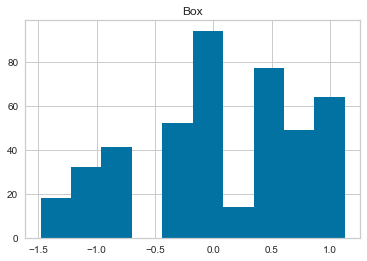

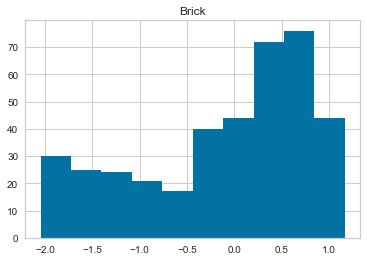

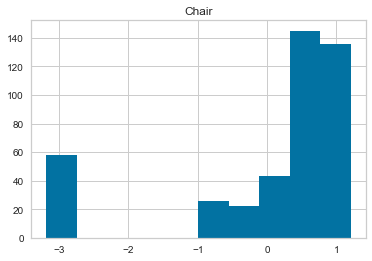

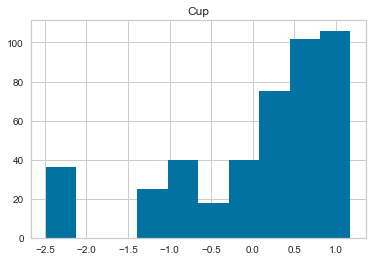

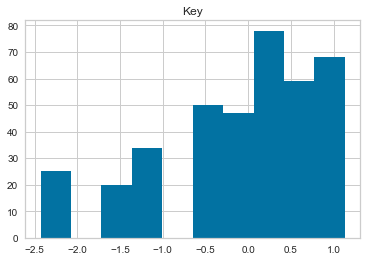

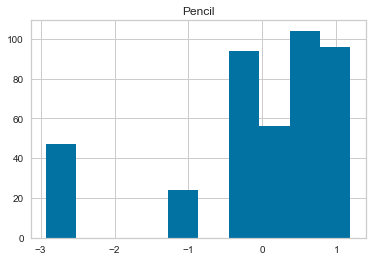

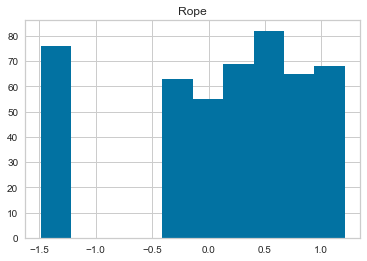

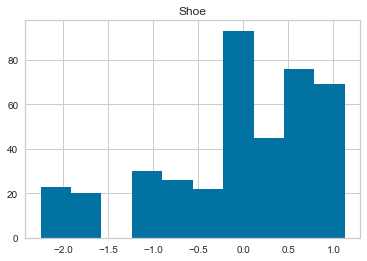

In [62]:
sp='cbow_6_ukwac_subtitle'
for stim in orig_df['item'].unique():
    orig_df.loc[orig_df['item']==stim,'originality_'+sp].hist()
    plt.title(stim)
    plt.show()
    plt.close()

In [59]:
metrics=['originality_'+sp for sp in splist]
orig_df['originality_mean']=orig_df[metrics].mean(axis=1)
metrics = metrics+['originality_mean']
orig_df[metrics]=(orig_df[metrics]-orig_df[metrics].mean())/orig_df[metrics].std()

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [60]:
orig_df[metrics].corr()

,originality_cbow_6_ukwac_subtitle,originality_cbow_subtitle,originality_glove_6B,originality_TASA,originality_mean
originality_cbow_6_ukwac_subtitle,1.000000,0.776848,0.581051,0.765729,0.908571
originality_cbow_subtitle,0.776848,1.000000,0.506168,0.785962,0.899102
originality_glove_6B,0.581051,0.506168,1.000000,0.518944,0.734572
originality_TASA,0.765729,0.785962,0.518944,1.000000,0.900996
originality_mean,0.908571,0.899102,0.734572,0.900996,1.000000


In [65]:
orig_df.to_csv('/Users/yyu/Box Sync/ORG-SCHOOL-WCAS-PSYCHOLOGY-BEEMAN-LAB/COAT/scoring/junk/results_originality.csv')

In [66]:
sd_df[metrics]=orig_df[metrics]

In [68]:
sd_df.corr().loc[metrics,metricsGrp]

,SemDis_MEAN,ewm_MEAN,min_MEAN,novelty_m
originality_cbow_6_ukwac_subtitle,0.352234,0.391499,0.477576,0.446113
originality_cbow_subtitle,0.394644,0.496528,0.554683,0.472673
originality_glove_6B,0.209073,0.213998,0.291312,0.314700
originality_TASA,0.343135,0.422358,0.515186,0.486091
originality_mean,0.380613,0.448678,0.539513,0.502459


In [69]:
sd_df.corr().loc[metrics,metricsGrp1]

,SemDis_TASA_nf_m,SemDis_cbowBNCwikiukwac_nf_m,SemDis_cbowsubtitle_nf_m,SemDis_cbowukwacsubtitle_nf_m,SemDis_glove_nf_m
originality_cbow_6_ukwac_subtitle,0.368105,0.286829,0.338243,0.349368,0.216798
originality_cbow_subtitle,0.403509,0.329721,0.404073,0.383885,0.233956
originality_glove_6B,0.254828,0.147385,0.184019,0.204982,0.129629
originality_TASA,0.375353,0.271199,0.350604,0.342262,0.189242
originality_mean,0.409444,0.304142,0.375436,0.375227,0.224961


In [70]:
sd_df.corr().loc[metrics,metricsGrp2]

,ewm_TASA,ewm_cbow_subtitle,ewm_cbow_6_ukwac_subtitle,ewm_glove_6B
originality_cbow_6_ukwac_subtitle,0.378228,0.370425,0.391112,0.256362
originality_cbow_subtitle,0.432735,0.496746,0.490286,0.350903
originality_glove_6B,0.260930,0.192136,0.202063,0.108009
originality_TASA,0.399471,0.408135,0.418939,0.279628
originality_mean,0.430256,0.432721,0.442604,0.294452


# Flexibility/diversity

In [71]:
folder='/Users/yyu/PycharmProjects/AUT-Scoring/data/flexibility/official/'
file='autdata_flex_results_cleaned.xlsx'

xls = pd.ExcelFile(folder+file)
df =pd.DataFrame()
for i in range(8):
    df=pd.concat([df,xls.parse(i)])
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3403 entries, 0 to 431
Data columns (total 4 columns):
id          3403 non-null int64
stim        3403 non-null object
response    3403 non-null object
category    3360 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 132.9+ KB


In [76]:
df[(df['id']==1087)&(df['stim']=='Box')]

,id,stim,response,category
46,1087,Box,storage,1.0
47,1087,Box,home for ducks,4.0
48,1087,Box,piggy bank,3.0
49,1087,Box,playpen for children,4.0


In [94]:
alldata=[]
for i,g in df.groupby(['id','stim']):
    cnt=len(g['category'].unique())
    alldata.append([i[0],i[1],cnt])
cat_df=pd.DataFrame(alldata,columns={'id','item','nCat'})
cat_df.head()

,id,item,nCat
0,1087,Box,3
1,1087,Brick,3
2,1087,Chair,4
3,1087,Cup,3
4,1087,Key,2


In [95]:
cat_df=sd_df.groupby(['id','item']).mean()[metrics+metricsGrp].reset_index().merge(cat_df,left_on=['id','item'],right_on=['id','item'])

In [96]:
cat_df.corr().loc['nCat']

id                                  -0.061430
originality_cbow_6_ukwac_subtitle    0.234240
originality_cbow_subtitle            0.183600
originality_glove_6B                 0.187800
originality_TASA                     0.191750
originality_mean                     0.234664
SemDis_MEAN                          0.013711
ewm_MEAN                             0.068182
min_MEAN                             0.182189
novelty_m                            0.365824
nCat                                 1.000000
Name: nCat, dtype: float64

In [330]:
flex_df=sd_df[['id','item','response','response_processed']]
flex_df['response_processed']=flex_df.apply(lambda r: eval(r['response_processed']), axis=1)

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [343]:
sp=splist[1]
utilities.dispersion_vectors([['table']],semspace_dict[sp])

(-4.440892098500626e-16, 4.440892098500626e-16)

In [344]:
utilities.dispersion_vectors([['table'],['table']],semspace_dict[sp])

(-4.440892098500626e-16, 4.440892098500626e-16)

In [352]:
utilities.dispersion_vectors([['table'],['bow']],semspace_dict[sp])

(0.2572194387923544, 0.2572194387923543)

In [346]:
utilities.dispersion_vectors([['table'],['chair'],['chair']],semspace_dict[sp])

(0.2997823520182856, 0.18124602946774251)

In [348]:
utilities.dispersion_vectors([['table'],['chair'],['chair'],['desk']],semspace_dict[sp])

(0.3373090031998828, 0.24343404186364515)

In [350]:
utilities.dispersion_vectors([['table'],['chair'],['chair'],['desk'],['desk']],semspace_dict[sp])

(0.34985127490363, 0.23678493276104107)

In [192]:

alldata=[]
for i,g in flex_df.groupby(['id','item']):
    tmp=[i[0],i[1]]
    for sp in splist:
        tmp=tmp+list(utilities.dispersion_vectors(g['response_processed'].values.tolist(),semspace_dict[sp]))
    alldata.append(tmp)
columnnames=['id','item']
for sp in splist:
    columnnames=columnnames+['dispMax_'+sp,'dispVar_'+sp]
disp_df=pd.DataFrame(alldata,columns=columnnames)
disp_df.head()

,id,item,dispMax_cbow_6_ukwac_subtitle,dispVar_cbow_6_ukwac_subtitle,dispMax_cbow_subtitle,dispVar_cbow_subtitle,dispMax_glove_6B,dispVar_glove_6B,dispMax_TASA,dispVar_TASA
0,1087,Box,0.511133,0.450911,0.498620,0.474570,0.721733,0.576914,0.547451,0.504865
1,1087,Brick,0.703763,0.580512,0.610198,0.566628,0.749936,0.608155,0.662801,0.580500
2,1087,Chair,0.643097,0.557730,0.663514,0.569337,0.961296,0.655672,0.644059,0.578499
3,1087,Cup,0.578858,0.469661,0.684959,0.572062,0.621046,0.544855,0.648116,0.606493
4,1087,Key,0.489473,0.420228,0.470354,0.438570,0.627107,0.336656,0.588258,0.512673


In [193]:
disp_df
disp_df=disp_df.merge(cat_df,left_on=['id','item'],right_on=['id','item'])

In [196]:
disp_df['dispMax_m']=disp_df[['dispMax_'+sp for sp in splist]].mean(axis=1)
disp_df['dispVar_m']=disp_df[['dispVar_'+sp for sp in splist]].mean(axis=1)

In [198]:
disp_df.corr()[['dispMax_m','dispVar_m']]

,dispMax_m,dispVar_m
id,0.007263,0.015393
dispMax_cbow_6_ukwac_subtitle,0.918545,0.895750
dispVar_cbow_6_ukwac_subtitle,0.888588,0.959654
dispMax_cbow_subtitle,0.910954,0.912954
dispVar_cbow_subtitle,0.904359,0.961867
dispMax_glove_6B,0.875286,0.775900
dispVar_glove_6B,0.870368,0.882141
dispMax_TASA,0.872963,0.886382
dispVar_TASA,0.878216,0.930935
originality_cbow_6_ukwac_subtitle,0.325909,0.371260


In [354]:
disp_df.to_csv('/Users/yyu/Box Sync/ORG-SCHOOL-WCAS-PSYCHOLOGY-BEEMAN-LAB/COAT/scoring/junk/results_dispersion.csv')

# All together

In [203]:
alldata=[]
for i,g in flex_df.groupby(['id','item']):
    tmp=[i[0],i[1]]
    if len([x for x in g['response_processed'].values.tolist() if len(x)==0])>0:
        print(i, g['response_processed'].values.tolist())
    alldata.append([i[0],i[1],len([x for x in g['response_processed'].values.tolist() if len(x)>0])])
print(alldata[:3])

(1118, 'Chair') [['seat'], ['block', 'door'], ['climb'], [], ['friend', 'ship', 'bracelet']]
(1118, 'Key') [['lock', 'door'], ['weapon'], [], ['necklace']]
(1159, 'Box') [[], ['sit'], ['play'], ['break', 'apart', 'us'], ['delivery'], ['wrap']]
(1195, 'Shoe') [['throw'], ['run'], ['mulch'], [], ['sell']]
(1407, 'Box') [['toy'], [], ['stool']]
(1425, 'Box') [[], ['block', 'area'], ['trap', 'animal'], ['stand']]
(1442, 'Box') [['ship'], ['sledding'], ['draw'], ['play', 'drinking', 'game', 'write'], ['cut'], ['hat'], ['hide'], ['bury'], [], ['buy', 'grocery'], ['sit'], ['shred'], ['wallpaper']]
(1513, 'Shoe') [[], ['ground', 'skin', 'barrier'], ['mountain', 'climbing'], ['biking'], ['dress'], ['dancing'], ['throwing'], ['eating', 'metaphorically']]
(1525, 'Box') [[], ['cut', 'open', 'floor', 'mat'], ['support'], ['let', 'cat', 'play'], ['return']]
(1531, 'Box') [['inside'], ['art', 'craft'], [], ['hide', 'inside']]
(1531, 'Brick') [['build', 'building'], ['throwing'], ['decoration'], []]
(

In [207]:
disp_df[disp_df['id']==1118][['item','fluency']]

,item,fluency
40,Box,4
41,Brick,5
42,Chair,4
43,Cup,5
44,Key,3
45,Pencil,6
46,Rope,4
47,Shoe,3


In [204]:
columnnames=['id','item','fluency']
disp_df=disp_df.merge(pd.DataFrame(alldata,columns=columnnames),left_on=['id','item'],right_on=['id','item'])
disp_df.head()

,id,item,dispMax_cbow_6_ukwac_subtitle,dispVar_cbow_6_ukwac_subtitle,dispMax_cbow_subtitle,dispVar_cbow_subtitle,dispMax_glove_6B,dispVar_glove_6B,dispMax_TASA,dispVar_TASA,...,originality_TASA,originality_mean,SemDis_MEAN,ewm_MEAN,min_MEAN,novelty_m,nCat,dispMax_m,dispVar_m,fluency
0,1087,Box,0.511133,0.450911,0.498620,0.474570,0.721733,0.576914,0.547451,0.504865,...,-0.208028,-0.177131,0.139193,0.279498,0.398051,0.833859,3,0.569734,0.501815,4
1,1087,Brick,0.703763,0.580512,0.610198,0.566628,0.749936,0.608155,0.662801,0.580500,...,0.008535,-0.309219,-0.168545,0.106239,0.290484,0.503336,3,0.681675,0.583949,6
2,1087,Chair,0.643097,0.557730,0.663514,0.569337,0.961296,0.655672,0.644059,0.578499,...,0.071656,0.056802,0.072505,0.296057,0.187510,0.172813,4,0.727991,0.590310,6
3,1087,Cup,0.578858,0.469661,0.684959,0.572062,0.621046,0.544855,0.648116,0.606493,...,-0.441108,-0.326006,0.609803,-0.033496,-0.022227,0.090182,3,0.633245,0.548268,6
4,1087,Key,0.489473,0.420228,0.470354,0.438570,0.627107,0.336656,0.588258,0.512673,...,-0.143304,-0.260897,0.873816,1.037597,0.381711,-0.033764,2,0.543798,0.427032,4


In [209]:
metrics

['originality_cbow_6_ukwac_subtitle',
 'originality_cbow_subtitle',
 'originality_glove_6B',
 'originality_TASA',
 'originality_mean']

In [214]:
metrics_agg=['originality_mean','dispVar_m','dispMax_m','ewm_MEAN','min_MEAN','SemDis_MEAN','novelty_m','nCat','fluency']

In [215]:
disp_df.corr().loc[metrics_agg,metrics_agg]

,originality_mean,dispVar_m,dispMax_m,ewm_MEAN,min_MEAN,SemDis_MEAN,novelty_m,nCat,fluency
originality_mean,1.000000,0.403020,0.356919,0.247846,0.323411,0.212182,0.402108,0.234664,0.354246
dispVar_m,0.403020,1.000000,0.951903,0.263974,0.377659,0.190687,0.412886,0.448170,0.801172
dispMax_m,0.356919,0.951903,1.000000,0.212066,0.308641,0.156406,0.349431,0.420803,0.790111
ewm_MEAN,0.247846,0.263974,0.212066,1.000000,0.800295,0.753595,0.207636,0.068182,0.029408
min_MEAN,0.323411,0.377659,0.308641,0.800295,1.000000,0.576208,0.354804,0.182189,0.146908
SemDis_MEAN,0.212182,0.190687,0.156406,0.753595,0.576208,1.000000,0.184146,0.013711,-0.018865
novelty_m,0.402108,0.412886,0.349431,0.207636,0.354804,0.184146,1.000000,0.365824,0.366436
nCat,0.234664,0.448170,0.420803,0.068182,0.182189,0.013711,0.365824,1.000000,0.475198
fluency,0.354246,0.801172,0.790111,0.029408,0.146908,-0.018865,0.366436,0.475198,1.000000


In [217]:
disp_df.columns

Index(['id', 'item', 'dispMax_cbow_6_ukwac_subtitle',
       'dispVar_cbow_6_ukwac_subtitle', 'dispMax_cbow_subtitle',
       'dispVar_cbow_subtitle', 'dispMax_glove_6B', 'dispVar_glove_6B',
       'dispMax_TASA', 'dispVar_TASA', 'originality_cbow_6_ukwac_subtitle',
       'originality_cbow_subtitle', 'originality_glove_6B', 'originality_TASA',
       'originality_mean', 'SemDis_MEAN', 'ewm_MEAN', 'min_MEAN', 'novelty_m',
       'nCat', 'dispMax_m', 'dispVar_m', 'fluency'],
      dtype='object')

In [216]:
icc_df=pd.DataFrame()
for col in metrics_agg:
    icc = pg.intraclass_corr(data=disp_df, targets='id', raters='item', ratings=col,nan_policy='omit')
    icc_df=pd.concat([icc_df,pd.DataFrame(icc.set_index('Type').loc['ICC3k']).T])
icc_df['metrics']=metrics_agg
icc_df=icc_df.drop(labels=['Description'],axis=1).set_index('metrics')
icc_df

,ICC,F,df1,df2,pval,CI95%
metrics,,,,,,
originality_mean,0.678638,3.11175,86,602,6.07483e-16,"[0.57, 0.77]"
dispVar_m,0.81883,5.51967,86,602,2.19727e-37,"[0.76, 0.87]"
dispMax_m,0.806334,5.16353,86,602,2.69522e-34,"[0.74, 0.86]"
ewm_MEAN,0.620263,2.6334,86,602,9.86528e-12,"[0.49, 0.73]"
min_MEAN,0.652427,2.87709,86,602,7.36044e-14,"[0.53, 0.75]"
SemDis_MEAN,0.748543,3.97682,86,602,9.77235e-24,"[0.66, 0.82]"
novelty_m,0.741256,3.86482,86,602,1.00146e-22,"[0.65, 0.82]"
nCat,0.693643,3.26416,86,602,2.62065e-17,"[0.59, 0.78]"
fluency,0.871303,7.77018,86,602,8.48901e-56,"[0.83, 0.91]"


In [218]:
disp_df[columnnames+['dispMax_m','dispVar_m']].to_csv('/Users/yyu/Box Sync/ORG-SCHOOL-WCAS-PSYCHOLOGY-BEEMAN-LAB/COAT/scoring/junk/results_agg.csv')

In [221]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo


In [222]:
metrics_agg

['originality_mean',
 'dispVar_m',
 'dispMax_m',
 'ewm_MEAN',
 'min_MEAN',
 'SemDis_MEAN',
 'novelty_m',
 'nCat',
 'fluency']

In [223]:
metrics_agg=['originality_mean','dispVar_m','ewm_MEAN','min_MEAN','SemDis_MEAN','novelty_m','nCat','fluency']

In [241]:
disp_df[metrics_agg]=(disp_df[metrics_agg]-disp_df[metrics_agg].mean())/disp_df[metrics_agg].std()

In [242]:
kmo_all,kmo_model=calculate_kmo(disp_df[metrics_agg])

In [243]:
kmo_model #this value is [0,1], less than .6 means FA is inadequent 

0.7207516715077898

In [265]:
fa = FactorAnalyzer(n_factors=3)
fa.fit(disp_df[metrics_agg])
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev #only need those EV greater than 1

array([3.33956033, 1.95652413, 0.7734821 , 0.69236373, 0.53682072,
       0.39821783, 0.1643784 , 0.13865274])

In [261]:
fa = FactorAnalyzer(n_factors=4)
fa.fit(disp_df[metrics_agg])
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev #only need those EV greater than 1

array([3.33956033, 1.95652413, 0.7734821 , 0.69236373, 0.53682072,
       0.39821783, 0.1643784 , 0.13865274])

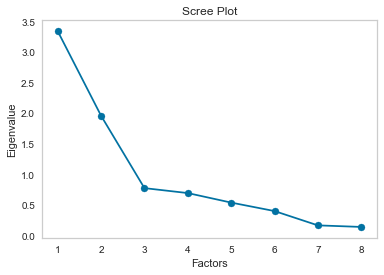

In [258]:
plt.scatter(range(1,disp_df[metrics_agg].shape[1]+1),ev)
plt.plot(range(1,disp_df[metrics_agg].shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

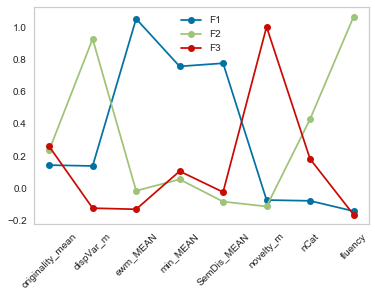

In [266]:
plt.plot(fa.loadings_,marker='o')
plt.grid()
plt.legend(['F1','F2','F3'])
plt.xticks(ticks=range(len(metrics_agg)),labels=metrics_agg,rotation=45)
plt.show()

In [267]:
fa.get_factor_variance()

(array([2.3468864 , 2.24798115, 1.17238102]),
 array([0.2933608 , 0.28099764, 0.14654763]),
 array([0.2933608 , 0.57435844, 0.72090607]))

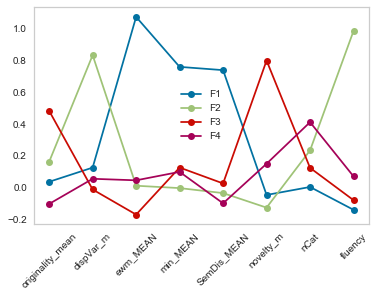

In [262]:
plt.plot(fa.loadings_,marker='o')
plt.grid()
plt.legend(['F1','F2','F3','F4'])
plt.xticks(ticks=range(len(metrics_agg)),labels=metrics_agg,rotation=45)
plt.show()

# Flexibility (tdidf, svd does not work)

In [124]:
from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()

In [125]:
for item in flex_df['item'].unique():
    idList=[]
    text=[]
    for i,g in flex_df[flex_df['item']==item].groupby('id'):
        idList.append(i)
        x=g['response_processed'].values
        wordlist=[item for sublist in x for item in sublist]
        text.append(' '.join([p_stemmer.stem(i) for i in wordlist]))
    break

In [126]:
text

['storag home duck piggi bank playpen child',
 'stand put item open close cut dollhous fill sleep',
 'store build fort umbrella catch bunni',
 'storag pack cardboard robot decor recycl think outsid present',
 'store build',
 'shoe pack stuff store present',
 'store step stool make dimension model charact packag ship hide',
 'cardboard ship mail ring brown cabl',
 'hold stool',
 'stuff insid fort stuff hide insid let cat carri stuff bowl present',
 'store item bed pet worn hat contain sell school project',
 'store item prop stand live boxcar',
 'carri book make play hous halloween costum make die stand',
 'sit play break apart us deliveri wrap',
 'hide store stool',
 'store hide organ ship',
 'insid someon head',
 'storag decor costum trash bin',
 'storag stool chair send hold anim',
 'contain cardboard fort carri case cat timeout place bed conceal underneath jail',
 'store item stand decor',
 'hold item build fort sail captur hide rip burn break fall',
 'hold item weigh toy kid tear cr

In [110]:
count_vectorizer = CountVectorizer()
response_vector = count_vectorizer.fit_transform(text)
print(count_vectorizer.get_feature_names())


['activity', 'allows', 'animal', 'apart', 'area', 'armor', 'art', 'artwork', 'away', 'bag', 'ball', 'bank', 'bed', 'bin', 'bird', 'blanket', 'block', 'body', 'book', 'bowl', 'boxcar', 'break', 'broken', 'brown', 'bug', 'build', 'building', 'bunny', 'burn', 'bury', 'buy', 'cable', 'canvas', 'capture', 'car', 'cardboard', 'carry', 'carrying', 'case', 'cat', 'catch', 'chair', 'character', 'child', 'childhood', 'closing', 'clothes', 'clothing', 'collecting', 'collection', 'collector', 'come', 'conceal', 'contain', 'container', 'costume', 'cover', 'covering', 'craft', 'create', 'cut', 'cutting', 'dance', 'decorate', 'decorating', 'decoration', 'decorative', 'delivering', 'delivery', 'design', 'device', 'die', 'dimensional', 'disassemble', 'dog', 'dollhouse', 'door', 'dragging', 'draw', 'drawn', 'drinking', 'drum', 'duck', 'eat', 'enter', 'fair', 'fall', 'fill', 'fire', 'fit', 'flattened', 'float', 'floor', 'fold', 'folded', 'food', 'fort', 'forth', 'fro', 'fun', 'functional', 'game', 'garba

In [113]:
type(response_vector)

scipy.sparse.csr.csr_matrix

In [112]:
np.shape(response_vector.toarray())

(89, 270)

In [127]:
tfidf_vectorizer = TfidfVectorizer()

tfidf = tfidf_vectorizer.fit_transform(text)


In [128]:
print(tfidf_vectorizer.get_feature_names())

['activ', 'allow', 'anim', 'apart', 'area', 'armor', 'art', 'artwork', 'away', 'bag', 'ball', 'bank', 'bed', 'bin', 'bird', 'blanket', 'block', 'bodi', 'book', 'bowl', 'boxcar', 'break', 'broken', 'brown', 'bug', 'build', 'bunni', 'buri', 'burn', 'buy', 'cabl', 'canva', 'captur', 'car', 'cardboard', 'carri', 'case', 'cat', 'catch', 'chair', 'charact', 'child', 'childhood', 'close', 'cloth', 'collect', 'collector', 'come', 'conceal', 'contain', 'costum', 'cover', 'craft', 'creat', 'cut', 'danc', 'decor', 'deliv', 'deliveri', 'design', 'devic', 'die', 'dimension', 'disassembl', 'dog', 'dollhous', 'door', 'drag', 'draw', 'drawn', 'drink', 'drum', 'duck', 'eat', 'enter', 'fair', 'fall', 'fill', 'fire', 'fit', 'flatten', 'float', 'floor', 'fold', 'food', 'fort', 'forth', 'fro', 'fun', 'function', 'game', 'garbag', 'gift', 'good', 'groceri', 'halloween', 'hat', 'head', 'height', 'held', 'help', 'hide', 'higher', 'hill', 'hold', 'home', 'hous', 'insid', 'instrument', 'insul', 'item', 'jail', 

In [129]:
tfidf.shape

(89, 239)

In [130]:
tsvd = TruncatedSVD(n_components=tfidf.shape[1]-1)
X_tsvd = tsvd.fit(tfidf)



In [136]:
for i in range(tfidf.shape[1]-1):
    tmp=X_tsvd.explained_variance_ratio_[:i].sum()
    print(i,tmp)
    if tmp>.95:
        n_com=i
        break

0 0.0
1 0.014338075844564221
2 0.052505858552418114
3 0.08913993944839715
4 0.12218620202776743
5 0.15307643942121163
6 0.18156196601973057
7 0.20840880059713335
8 0.23364907955189082
9 0.25812416531538246
10 0.2808029578032756
11 0.3030169972785626
12 0.32389975495402157
13 0.34423652442698616
14 0.36388212333059905
15 0.3828544677068636
16 0.4010646035290034
17 0.4192962246135779
18 0.43727027621043796
19 0.45478905017071236
20 0.47121908974423987
21 0.48736197652201835
22 0.5030341995397826
23 0.5181951847722218
24 0.5331948644671652
25 0.5477155695353787
26 0.562120611104551
27 0.575719244222414
28 0.5891769192813467
29 0.6020371212081801
30 0.6147686859674015
31 0.6270178521939832
32 0.6389162456326223
33 0.6505619776351148
34 0.6620238074146525
35 0.672985568731037
36 0.6839799524219277
37 0.6947078390278381
38 0.7052708335325495
39 0.7155494680094028
40 0.7255419799295788
41 0.7353054128024227
42 0.7448011234759943
43 0.7542208868101179
44 0.7634851455175007
45 0.772582838189568

In [137]:
tsvd = TruncatedSVD(n_components=n_com)
X_tsvd = tsvd.fit(tfidf)
X_tsvd.explained_variance_ratio_

array([0.01433808, 0.03816778, 0.03663408, 0.03304626, 0.03089024,
       0.02848553, 0.02684683, 0.02524028, 0.02447509, 0.02267879,
       0.02221404, 0.02088276, 0.02033677, 0.0196456 , 0.01897234,
       0.01821014, 0.01823162, 0.01797405, 0.01751877, 0.01643004,
       0.01614289, 0.01567222, 0.01516099, 0.01499968, 0.01452071,
       0.01440504, 0.01359863, 0.01345768, 0.0128602 , 0.01273157,
       0.01224916, 0.01189839, 0.01164573, 0.01146183, 0.01096177,
       0.01099438, 0.01072789, 0.01056299, 0.01027863, 0.00999251,
       0.00976342, 0.0094957 , 0.00941976, 0.00926425, 0.0090977 ,
       0.0089211 , 0.00870943, 0.00865498, 0.00837799, 0.0082929 ,
       0.00808895, 0.00790697, 0.00775754, 0.0076594 , 0.00751496,
       0.00747504, 0.00720825, 0.0071518 , 0.00690032, 0.00675077,
       0.0067055 , 0.00644511, 0.00613317, 0.00609384, 0.00595135,
       0.00588279, 0.00555234, 0.00534688, 0.005219  , 0.00487522,
       0.00455693])

In [139]:
reduced=X_tsvd.fit_transform(tfidf)
np.shape(reduced)

(89, 71)

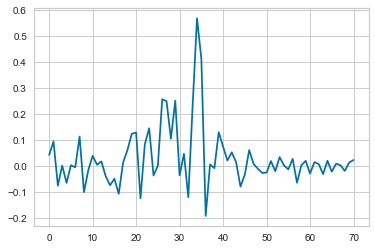

In [141]:
plt.plot(reduced[0,:])

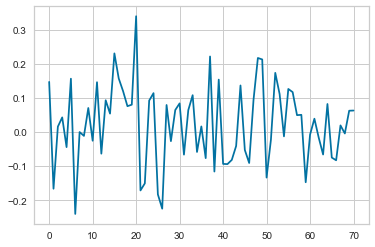

In [142]:
plt.plot(reduced[1,:])

In [143]:
np.shape(X_tsvd.components_)

(71, 239)

(array([1.800e+01, 1.480e+02, 1.208e+03, 7.792e+03, 6.663e+03, 9.290e+02,
        1.710e+02, 2.800e+01, 7.000e+00, 5.000e+00]),
 array([-0.34006424, -0.25392155, -0.16777885, -0.08163616,  0.00450653,
         0.09064922,  0.17679192,  0.26293461,  0.3490773 ,  0.43522   ,
         0.52136269]),
 <a list of 10 Patch objects>)

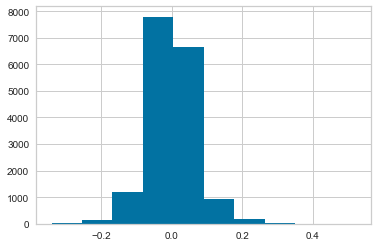

In [149]:
plt.hist(X_tsvd.components_.flatten())

In [163]:
rawFeatureN=len(tfidf_vectorizer.get_feature_names())
for i in range(10):
    #index=np.array(range(rawFeatureN))[np.abs(X_tsvd.components_[i,:])>0.15]
    index = np.flip(np.argsort(np.abs(X_tsvd.components_[i,:])))[:5]
    print([tfidf_vectorizer.get_feature_names()[i] for i in index])

['store', 'hide', 'stand', 'build', 'ship']
['store', 'item', 'hold', 'stool', 'storag']
['stool', 'fort', 'storag', 'step', 'build']
['hide', 'fort', 'ship', 'build', 'hold']
['hold', 'item', 'stand', 'build', 'fort']
['hold', 'move', 'build', 'mail', 'hide']
['item', 'build', 'pack', 'trap', 'move']
['storag', 'cat', 'hous', 'stuff', 'move']
['insid', 'stuff', 'storag', 'ship', 'sit']
['item', 'stand', 'costum', 'hold', 'stuff']
